# Results from edge testing

## Libraries

In [1]:
suppressMessages({
  library(here)
  library(readr)
  library(dplyr)
  library(tidyr)
  library(purrr)
  library(ggplot2)
})

In [2]:
options(repr.plot.res = 300)

In [3]:
edge_table_totest <- read_tsv(here('data/edge_table_totest.tsv'), show_col_types = FALSE)
head(edge_table_totest)

NODE1,CIS,NODE2,CHROM,start,end
<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>
FG,FALSE,AGRP,NA,NA,NA
IFC,FALSE,PON3,NA,NA,NA
HDL,FALSE,HMOX1,NA,NA,NA
HDL,FALSE,APOM,NA,NA,NA
TG,FALSE,APOM,NA,NA,NA
TG,FALSE,LDLR,NA,NA,NA


In [12]:
edge_table_results <- edge_table_totest |>
  mutate(
    RESOBJ = map2(
      NODE1, NODE2,
      ~readRDS(here(paste0('data/EdgeTests/', .x, '_', .y, '.rds')))
    )
  )
print(edge_table_results)

# A tibble: 58 × 7
   NODE1    CIS   NODE2  CHROM start   end RESOBJ          
   <chr>    <lgl> <chr>  <dbl> <dbl> <dbl> <list>          
 1 FG       FALSE AGRP      NA    NA    NA <named list [3]>
 2 IFC      FALSE PON3      NA    NA    NA <named list [3]>
 3 HDL      FALSE HMOX1     NA    NA    NA <named list [3]>
 4 HDL      FALSE APOM      NA    NA    NA <named list [3]>
 5 TG       FALSE APOM      NA    NA    NA <named list [3]>
 6 TG       FALSE LDLR      NA    NA    NA <named list [3]>
 7 TG       FALSE AGRP      NA    NA    NA <named list [3]>
 8 TG       FALSE LPL       NA    NA    NA <named list [3]>
 9 BasalISR FALSE LEP       NA    NA    NA <named list [3]>
10 BasalISR FALSE IGFBP1    NA    NA    NA <named list [3]>
# ℹ 48 more rows


In [13]:
edge_table_results |>
  filter(!CIS) |>
  slice(1) |>
  pluck('RESOBJ', 1, 'RESDF')

BETA_IVW,SE_IVW,BETA_Egger,SE_Egger,B0_Egger,B0SE_Egger,PVAL_IVW,QDF_IVW,QSTAT_IVW,QPVAL_IVW,PVAL_Egger,PVAL_B0Egger,QSTAT_Egger,QPVAL_Egger
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.04154762,0.05916552,0.1846288,0.1190016,-0.003528362,0.002549737,0.4825377,106,220.6333,4.692537e-10,0.1207863,0.1664153,216.6816,9.247972e-10


In [14]:
edge_table_results |>
  filter(CIS) |>
  slice(1) |>
  pluck('RESOBJ', 1, 'RESDF')

CHROM,POS,RSID,EA,NEA,EAF_EXP,BETA_EXP,SE_EXP,PVAL_EXP,EAF_OUT,BETA_OUT,SE_OUT,PVAL_OUT,BETA_SMR,SE_SMR,PVAL_SMR,PVAL_HEIDI,NSNP_HEIDI
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16,67475802,rs77115810,G,A,0.986084,0.259008,0.0301088,7.80549e-18,0.986084,0.0106,0.0096,0.4595,0.04092538,0.03736857,0.273437,0.1082628,20


In [16]:
edge_table_resum <- edge_table_results |>
  transmute(
    Link = map2_chr(NODE1, NODE2, ~paste(sort(c(.x, .y)), collapse = ' - ')),
    CIS = ifelse(CIS, 'CisIns', 'PolyIns'),
    RESOBJ
  ) |>
  pivot_wider(names_from = CIS, values_from = RESOBJ) |>
  mutate(
    across(
      c(PolyIns, CisIns), 
      ~map(.x, 'RESDF')
    )
  ) |>
  unnest(c(PolyIns, CisIns)) |>
  transmute(
    Link, 
    BETA_IVW, SE_IVW, PVAL_IVW, NSNP_IVW = QDF_IVW + 1,
    BETA_Egger, SE_Egger, PVAL_Egger,
    B0_Egger, B0SE_Egger, PVAL_B0Egger, 
    BETA_SMR, SE_SMR, PVAL_SMR, PVAL_HEIDI, NSNP_HEIDI
  )
edge_table_resum

Link,BETA_IVW,SE_IVW,PVAL_IVW,NSNP_IVW,BETA_Egger,SE_Egger,PVAL_Egger,B0_Egger,B0SE_Egger,PVAL_B0Egger,BETA_SMR,SE_SMR,PVAL_SMR,PVAL_HEIDI,NSNP_HEIDI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AGRP - FG,0.04154762,0.05916552,4.825377e-01,107,0.18462883,0.11900162,1.207863e-01,-3.528362e-03,0.0025497369,1.664153e-01,0.0409253768,0.037368567,2.734370e-01,1.082628e-01,20
IFC - PON3,0.38361179,0.30785681,2.127379e-01,4,0.71119082,1.08654137,5.127604e-01,-1.912580e-02,0.0596944678,7.486691e-01,-0.0240272505,0.020971958,2.519256e-01,8.044591e-01,20
HDL - HMOX1,0.25875281,0.01790432,2.435828e-47,1855,0.27347644,0.02664411,1.023258e-24,-3.924718e-04,0.0005259176,4.555097e-01,0.0065671955,0.018400704,7.211673e-01,5.242227e-02,20
APOM - HDL,0.47019746,0.01791132,6.886373e-152,1855,0.46221665,0.02665776,2.392021e-67,2.126854e-04,0.0005260692,6.859982e-01,-0.0066287468,0.003956009,9.381366e-02,4.830991e-02,20
APOM - TG,-0.01454980,0.02280073,5.233899e-01,1643,0.01520560,0.03484953,6.626034e-01,-7.566199e-04,0.0006702113,2.589285e-01,0.0034418493,0.003952901,3.839099e-01,2.694476e-06,20
LDLR - TG,0.94678303,0.01771306,0.000000e+00,1643,0.92925678,0.02710557,1.412892e-257,4.448023e-04,0.0005206808,3.929551e-01,-0.0121862564,0.029074901,6.751188e-01,3.107855e-01,10
AGRP - TG,0.60039840,0.01544309,0.000000e+00,1643,0.60183934,0.02362689,3.963019e-143,-3.660833e-05,0.0004541889,9.357588e-01,0.0710402767,0.023867342,2.915936e-03,1.545416e-03,20
LPL - TG,-0.43127649,0.01972612,5.819363e-106,1643,-0.30331898,0.02995216,4.202540e-24,-3.236910e-03,0.0005741707,1.724982e-08,-0.1087926651,0.003740407,5.431846e-186,2.809319e-53,20
BasalISR - IGFBP1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,-0.3758849405,0.880607122,6.694904e-01,9.862586e-01,20


In [17]:
write_tsv(edge_table_resum, here('data/edge_table_resum.tsv'))

## Plot

In [8]:
gencode <- read_tsv(
  paste0(
    '/Users/da1078co/Documents/Data/GENCODE/',
    'gencode.v47lift37.basic.annotation.gtf.gz'
  ),
  comment = '#',
  col_types = 'cccnn-c-c',
  col_names = c(
    'CHROM', 'source', 'gene_type',
    'start', 'end', 'strand', 'addinfo'
  )
) |>
  filter(gene_type == 'gene') |>
  select(-gene_type) |>
  mutate(
    CHROM = gsub('chr', '', CHROM),
    gene_id = gsub(
      '^gene_id \"([^\"]+)\";.*',
      '\\1',
      addinfo
    ),
    gene_type = gsub(
      '.*gene_type \"([^\"]+)\";.*',
      '\\1',
      addinfo
    ),
    gene_name = gsub(
      '.*gene_name \"([^\"]+)\";.*',
      '\\1',
      addinfo
    )
  ) |>
  select(-addinfo)
head(gencode)

CHROM,source,start,end,strand,gene_id,gene_type,gene_name
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,HAVANA,10370,13118,+,ENSG00000308415.1_1,lncRNA,DDX11L2
1,HAVANA,11121,24894,+,ENSG00000290825.2_2,lncRNA,DDX11L16
1,HAVANA,12010,13670,+,ENSG00000223972.6_6,transcribed_unprocessed_pseudogene,DDX11L1
1,HAVANA,14356,30744,-,ENSG00000310526.1_1,lncRNA,WASH7P
1,HAVANA,14696,24886,-,ENSG00000227232.6_7,transcribed_unprocessed_pseudogene,WASH7P
1,HAVANA,28589,31109,+,ENSG00000243485.6_13,lncRNA,MIR1302-2HG


In [75]:
locuszoomfx <- function(LOCUSCHROM, RESTAB, GENENAME, TRAITNAME){
  p1d <- RESTAB[['DATDF']] |>
    transmute(
      POS, R2, TOP = RSID == RESTAB[['RESDF']]$RSID,
      Z_EXP = BETA_EXP / SE_EXP, Z_OUT = BETA_OUT / SE_OUT
    ) |>
    pivot_longer(starts_with('Z_'), names_to = c('.value', 'grp'), names_sep = '_') |>
    mutate(grp = factor(grp, levels = c('OUT', 'EXP'), labels = c(TRAITNAME, GENENAME)))
  p1 <- p1d |>
    ggplot(aes(POS, Z)) +
    geom_vline(xintercept = RESTAB[['RESDF']]$POS, lty = 'dashed', color = 'grey50') +
    geom_point(
      aes(
        color = R2, 
        size = ifelse(TOP, 1.5, .5), 
        alpha = ifelse(TOP, 0.7, .2)
      )
    ) +
    scale_size_identity() +
    scale_alpha_identity() +
    scale_color_viridis_c(option = 'plasma', direction = -1, begin = 0, end = .8) +
    geom_hline(yintercept = 0, lty = 'dashed') +
    facet_grid(grp ~ ., scales = 'free_y') +
    theme_bw() +
    theme(legend.position = 'top')
  p2d <- gencode %>%
    filter(
      CHROM == LOCUSCHROM, 
      start < max(RESTAB[['DATDF']]$POS),
      end > min(RESTAB[['DATDF']]$POS),
      gene_type == 'protein_coding'
    ) %>%
    mutate(
      start = ifelse(start < min(RESTAB[['DATDF']]$POS), min(RESTAB[['DATDF']]$POS), start),
      end = ifelse(end > max(RESTAB[['DATDF']]$POS), max(RESTAB[['DATDF']]$POS), end),
      xstart = ifelse(strand == "+", start, end),
      xend = ifelse(strand == "+", end, start)
    )
  p2 <- p2d %>%
    ggplot(
      aes(y = gene_name, x = xstart, xend = xend,
          yend = gene_name, label = gene_name)
    ) +
    geom_vline(xintercept = RESTAB[['RESDF']]$POS, lty = 'dashed', color = 'grey80') +
    geom_segment(arrow = arrow(length = unit(.05, "in")), alpha = .5, size = .2) +
    geom_text(
      aes(
        x = (xend + xstart) / 2, y = gene_name,
        size = ifelse(gene_name == GENENAME, 3, 2)
      ),
      fontface = "italic", vjust = -1.1
    ) +  
    geom_vline(xintercept = min(RESTAB[['DATDF']]$POS)) +
    geom_vline(xintercept = max(RESTAB[['DATDF']]$POS)) +
    scale_size_identity() +
    labs(x = paste("Chromosome", LOCUSCHROM), y = NULL) +
    theme_light() +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.border = element_blank(),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.line.x.bottom = element_line(colour = "black"))
  patchwork::wrap_plots(
    p1 + theme(axis.text.x = element_blank(), axis.title.x = element_blank()), 
    p2,
    ncol = 1, guides = "collect",
    heights = c(.7, .3)
  ) &
  theme(legend.position = "right") &
  scale_x_continuous(labels = scales::comma, expand = expansion()) &
  coord_cartesian(clip = 'off')
}

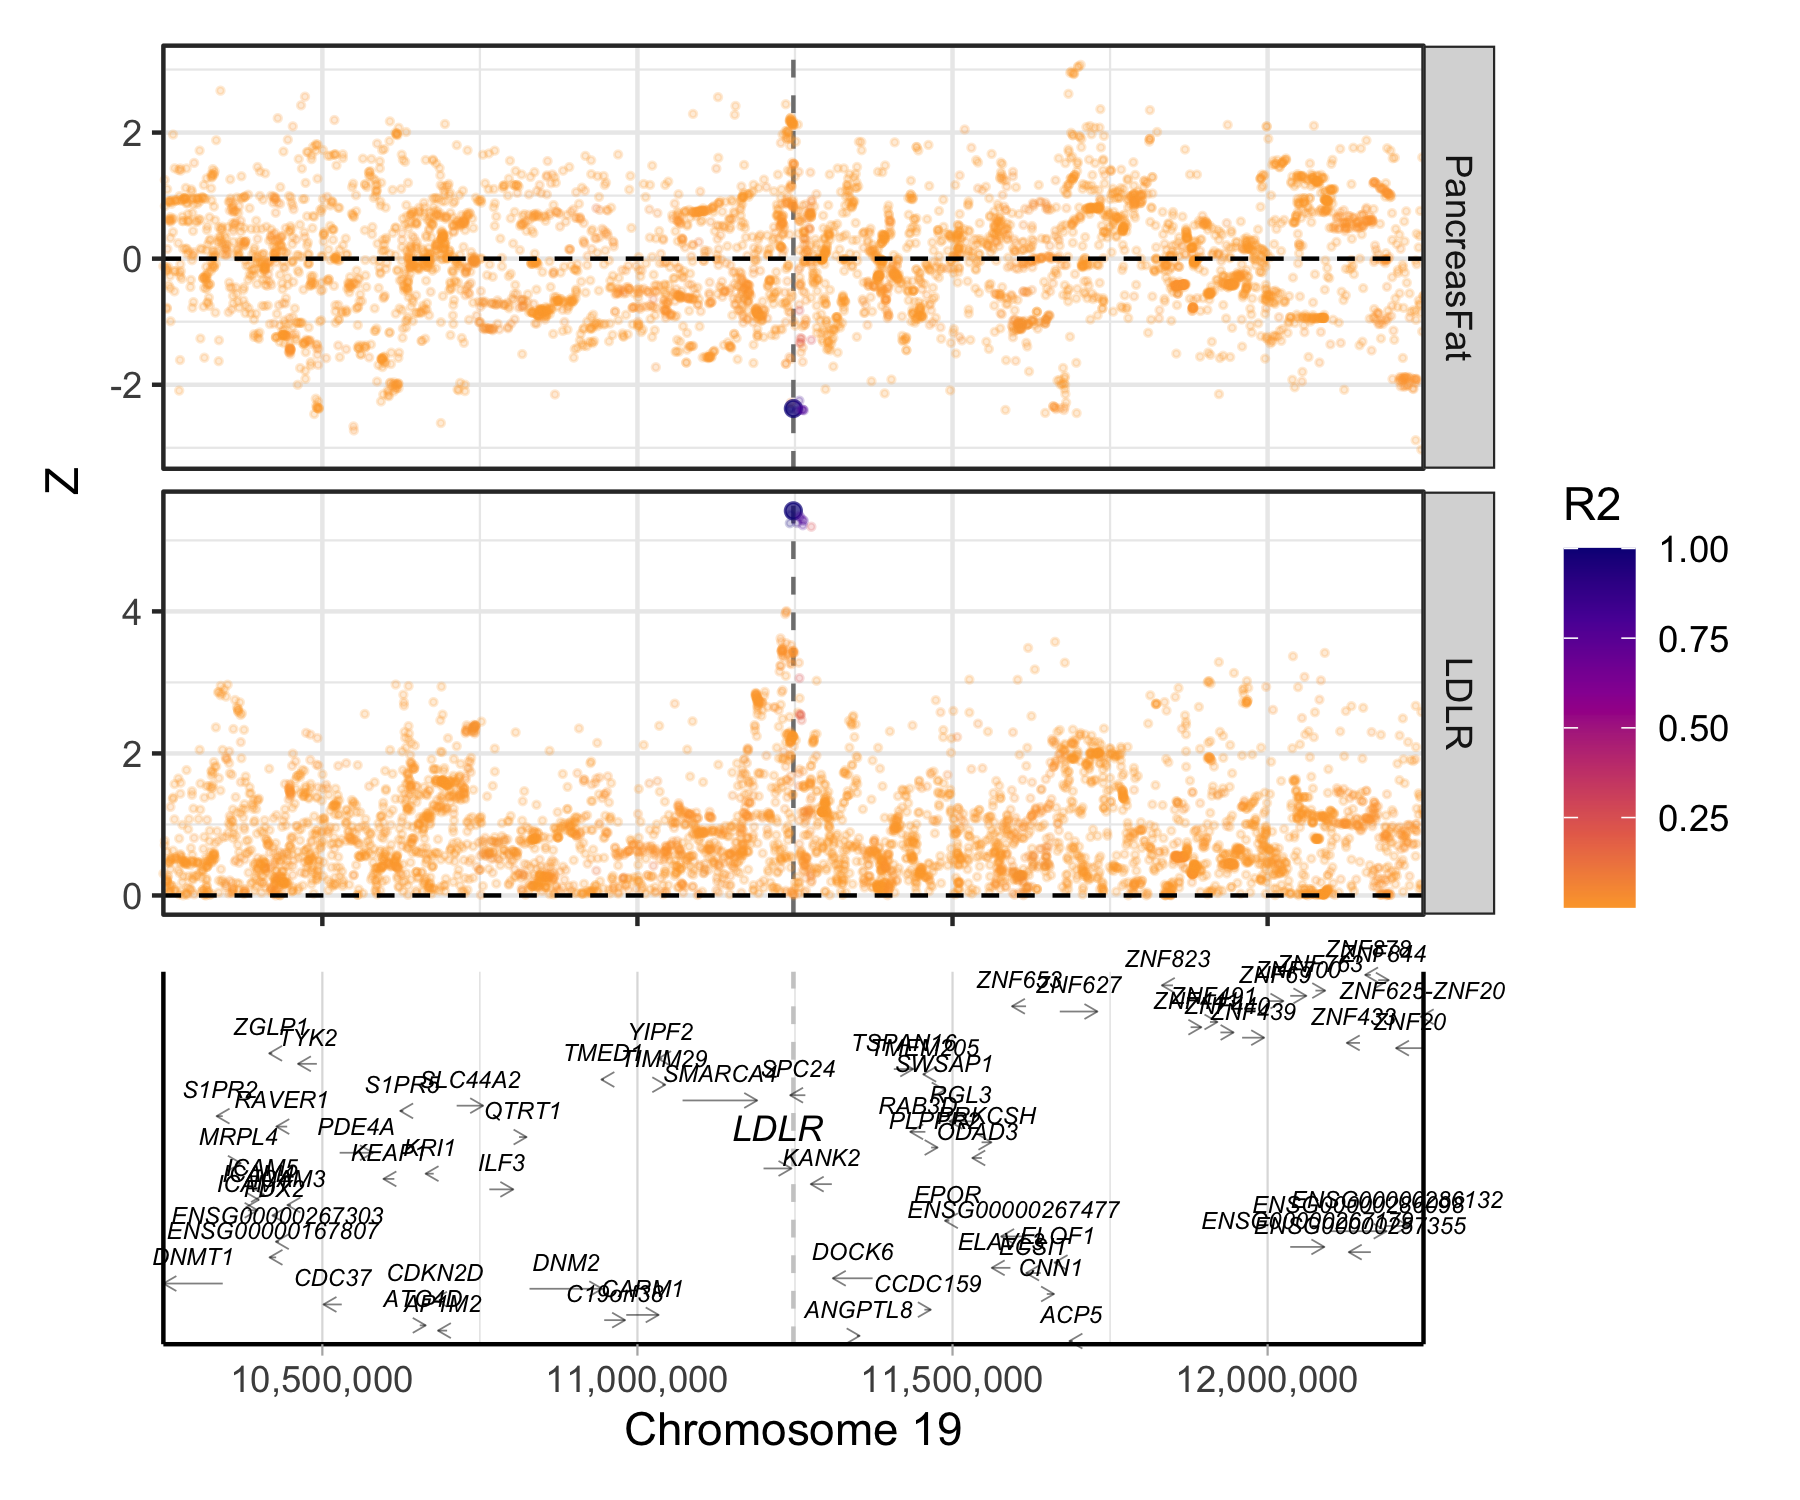

In [80]:
options(repr.plot.width = 6,repr.plot.height = 5)
test %>%
  mutate(
    lzp = pmap(
      list(CHROM, RES, gene_name, trait_name),
      ~locuszoomfx(..1, ..2, ..3, ..4)
    )
  ) %>%
  pluck('lzp', 1)